In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import pandas as pd
import io #Used as buffer

In [4]:
path= Path(f'../../data/cluster_results')

In [5]:
#freq1nn_w5nn_p3nn_s2nn_tw5nn_bs4nn_epoch3
def read_csv(f):
    df = pd.read_csv(f).mean()
    df['std'] = pd.read_csv(f).std().iloc[0] #remove this line to remove std from table

    df['experiment'] = f.parent.parent.parent.name
    df['function'] = f.parent.parent.name
    name = f.parent.name
    #print(name)
    df['freq'] = int(name[4:].split('n')[0])
    #print(df['freq'])
    df['method'] = f.name.split('_')[0]
    df['nn_p']=name[14:].split('n')[0] 

    return df

measure_name=['mof','sr','arr','nfe','nn_time']
index_measure=0

In [19]:
m = measure_name[index_measure]

files = list(f for f in path.glob(f'exp*/*/freq1nn_w5nn_p*nn_s3nn_tw5nn_bs4nn_epoch3/*{m}.csv') if 'NNnorm' in f.name) #path.glob(f'exp*/*/freq1*nn_s*nn_tw*bs*/*{m}.csv')
#print(files)
df = pd.DataFrame([read_csv(f) for f in files])
# data = pd.pivot_table(df, index=['experiment','function'], columns='method', values=m) #,'freq' later for adding frequency experiment
data = pd.pivot_table(df, index=['experiment','function','freq', 'nn_p' ],columns='method' ) #,'freq' later for adding frequency experiment, ,values=m 'ns','tw', 'bs','epochs'
data.style.format("{:,.2f}")


In [24]:
import altair as alt
alt.renderers.enable('notebook')
# DataFrame we use for plots

d = data.reset_index()
d.columns = ['experiment', 'function', 'freq', 'nn_p', 'NNnorm', 'NNnorm_std']
d.head(2)
d1 = d.melt(['experiment','function','freq','nn_p'], value_vars=['NNnorm'],
            var_name='method', value_name='mof')
d2 = d.melt(['experiment','function','freq', 'nn_p'], value_vars=['NNnorm_std'],
            var_name='method', value_name='mof_std')
d2.method = d2.method.str.replace('_std', '')
d = d1.merge(d2)
d.head()

,experiment,function,freq,nn_p,method,mof,mof_std
0,exp1,rastrigin,1,1,NNnorm,18.878982,5.608049
1,exp1,rastrigin,1,3,NNnorm,15.774672,5.598021
2,exp1,rastrigin,1,5,NNnorm,17.387583,5.236933
3,exp1,rastrigin,1,8,NNnorm,20.675668,5.427539
4,exp1,rosenbrock,1,1,NNnorm,131859.437247,154609.548966


In [52]:
test = d.query("experiment=='exp1'").copy()  # & freq==1"
mins = test.groupby('function')['mof'].min()
test['mof_norm'] = test['mof']
for k,v in mins.iteritems():
    test.loc[test.function==k,'mof_norm'] = test.loc[test.function==k,'mof']/v
test.head()

,experiment,function,freq,nn_p,method,mof,mof_std,mof_norm
0,exp1,rastrigin,1,1,NNnorm,18.878982,5.608049,1.196791
1,exp1,rastrigin,1,3,NNnorm,15.774672,5.598021,1.000000
2,exp1,rastrigin,1,5,NNnorm,17.387583,5.236933,1.102247
3,exp1,rastrigin,1,8,NNnorm,20.675668,5.427539,1.310688
4,exp1,rosenbrock,1,1,NNnorm,131859.437247,154609.548966,1.844971


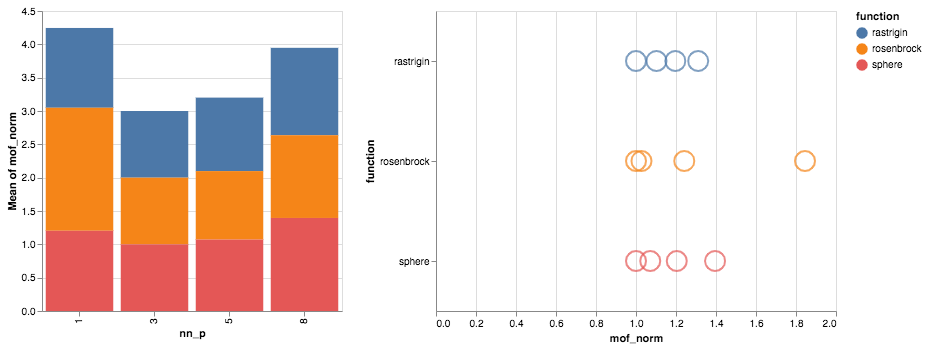

In [53]:
base = alt.Chart(test)
selector1 = alt.selection_single(fields=['nn_p'])

chart1 = base.mark_bar().encode(
    alt.X('nn_p'),
    alt.Y('mean(mof_norm)'),
    alt.Color('function'),
    opacity = alt.condition(selector1, alt.OpacityValue(1.0), alt.OpacityValue(0.1))
).properties(
    width=300
).add_selection(selector1)

chart2 = base.mark_point(size=400).encode(
    alt.X('mof_norm'),
    alt.Y('function'),
    alt.Color('function'),
   # alt.Shape('freq:N'),
    alt.Tooltip(['mof_norm','mof','freq','function'])
).transform_filter(
    selector1
).properties(
#     width=200
    height=300
)

chart1|chart2

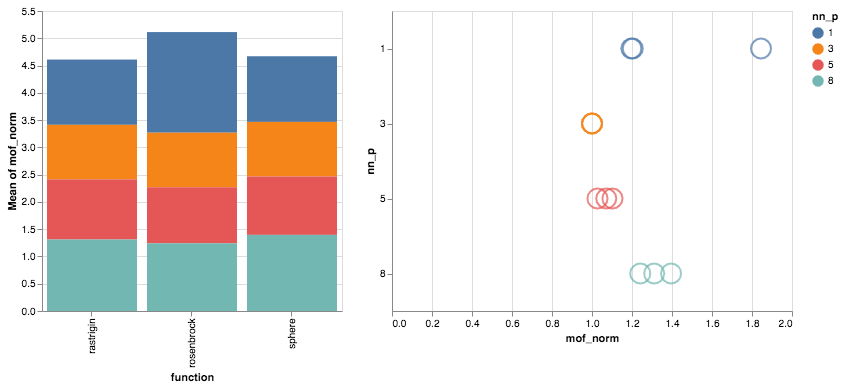

In [54]:
base = alt.Chart(test)
selector1 = alt.selection_single(fields=['function'])

chart1 = base.mark_bar().encode(
    alt.X('function'),
    alt.Y('mean(mof_norm)'),
    alt.Color('nn_p'),
    opacity = alt.condition(selector1, alt.OpacityValue(1.0), alt.OpacityValue(0.1))
).properties(
    width=300
).add_selection(selector1)

chart2 = base.mark_point(size=400).encode(
    alt.X('mof_norm'),
    alt.Y('nn_p'),
    alt.Color('nn_p'),
    #alt.Shape('freq:N'),
    alt.Tooltip(['mof_norm','mof','freq','function'])
).transform_filter(
    selector1
).properties(
#     width=200
    height=300
)

chart1|chart2.interactive()